In [2]:
import warnings
warnings.filterwarnings('ignore')

print("Loading PyTorch (this may take 1-2 minutes on first run)...")
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading other libraries...")
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread

print("Loading PPN2V modules...")
from ppn2v.pn2v import gaussianMixtureNoiseModel
from ppn2v.pn2v import histNoiseModel
from ppn2v.pn2v.utils import plotProbabilityDistribution

print("All imports complete!")

Loading PyTorch (this may take 1-2 minutes on first run)...
Using device: cpu
Loading other libraries...
Using device: cpu
Loading other libraries...
Loading PPN2V modules...
Loading PPN2V modules...
All imports complete!
All imports complete!


### Configure Paths

In [3]:
# Path to prepared data (from Step 0)
path = './'

# Data name (must match Step 0)
dataName = 'dataset01'

# GMM parameters (standard settings)
n_gaussian = 3  # Number of Gaussian components in mixture
n_coeff = 2     # Polynomial coefficients (2 = linear relationship)

### Load Signal and Observation for Calibration

In [4]:
# Load the signal (jittered image = clean for noise calibration purposes)
signal = imread(path + f'{dataName}_signal.tif')
print(f"Signal shape: {signal.shape}")
print(f"Signal range: [{signal.min():.4f}, {signal.max():.4f}]")

# Load the observation (noisy image)
observation = imread(path + f'{dataName}_noisy.tif')
print(f"\nObservation shape: {observation.shape}")
print(f"Observation range: [{observation.min():.4f}, {observation.max():.4f}]")

# For calibration, we need matching dimensions
# Signal is 2D, observation might be 3D (1, H, W) from Step 0
if len(observation.shape) == 3 and observation.shape[0] == 1:
    observation_2d = observation[0]
else:
    observation_2d = observation

print(f"\nShapes for calibration:")
print(f"  Signal: {signal.shape}")
print(f"  Observation: {observation_2d.shape}")

Signal shape: (128, 128)
Signal range: [0.0000, 254.0000]

Observation shape: (1, 128, 128)
Observation range: [0.0000, 255.0000]

Shapes for calibration:
  Signal: (128, 128)
  Observation: (128, 128)


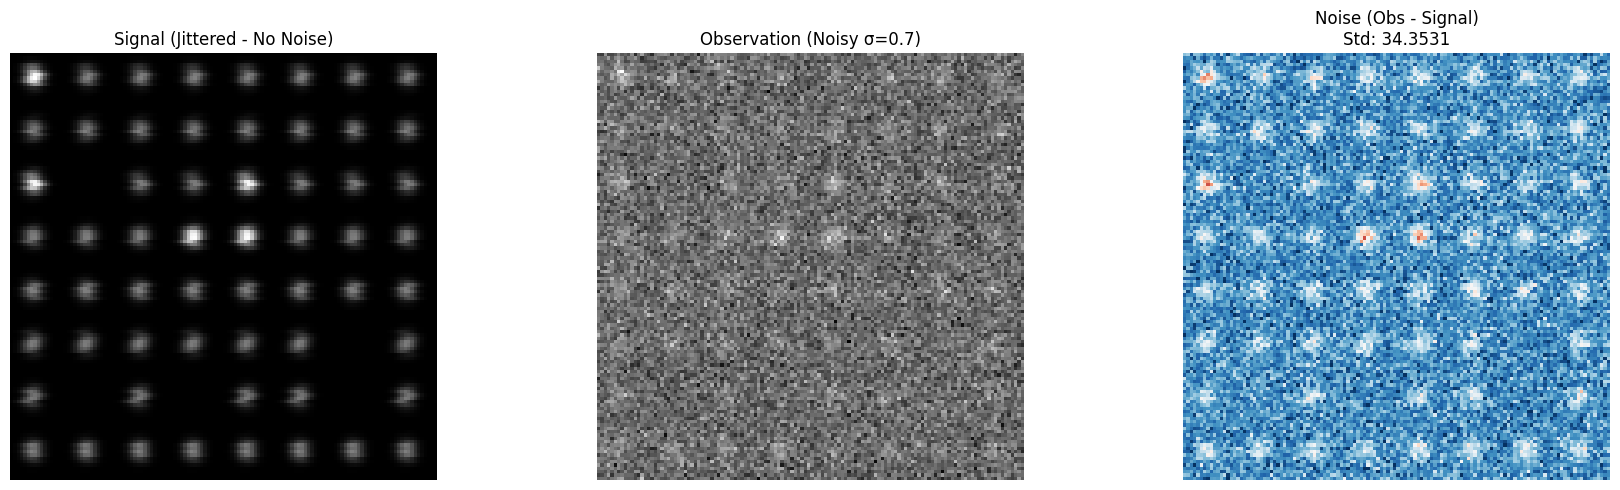


Noise Statistics:
  Mean: 96.563293 (should be ~0 for Gaussian)
  Std:  34.353130
  Min:  -109.0000
  Max:  225.0000


In [5]:
# Visualize the calibration pair
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(signal, cmap='gray')
axes[0].set_title('Signal (Jittered - No Noise)')
axes[0].axis('off')

axes[1].imshow(observation_2d, cmap='gray')
axes[1].set_title('Observation (Noisy σ=0.7)')
axes[1].axis('off')

# Show the noise (difference)
noise = observation_2d - signal
axes[2].imshow(noise, cmap='RdBu', vmin=-np.percentile(np.abs(noise), 99), 
               vmax=np.percentile(np.abs(noise), 99))
axes[2].set_title(f'Noise (Obs - Signal)\nStd: {noise.std():.4f}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Noise statistics
print(f"\nNoise Statistics:")
print(f"  Mean: {noise.mean():.6f} (should be ~0 for Gaussian)")
print(f"  Std:  {noise.std():.6f}")
print(f"  Min:  {noise.min():.4f}")
print(f"  Max:  {noise.max():.4f}")

### Create Histogram Noise Model

The histogram represents P(observation | signal) as a 2D lookup table.

In [6]:
# Determine intensity range from the data
# Using both signal and observation to cover full range
all_values = np.concatenate([signal.flatten(), observation_2d.flatten()])
minVal = np.percentile(all_values, 0.5)
maxVal = np.percentile(all_values, 99.5)
bins = 256

print(f"Histogram parameters:")
print(f"  Range: [{minVal:.4f}, {maxVal:.4f}]")
print(f"  Bins: {bins}")

Histogram parameters:
  Range: [0.0000, 185.0000]
  Bins: 256


In [7]:
# For histogram creation, need arrays in shape (N, H, W)
# Since we have a single calibration pair, expand dims
signal_for_hist = signal[np.newaxis, ...] if len(signal.shape) == 2 else signal
obs_for_hist = observation_2d[np.newaxis, ...] if len(observation_2d.shape) == 2 else observation_2d

print(f"Signal for histogram: {signal_for_hist.shape}")
print(f"Observation for histogram: {obs_for_hist.shape}")

# Create histogram noise model
nameHistNoiseModel = f'HistNoiseModel_{dataName}_calibration'

print(f"\nCreating histogram noise model...")
histogram = histNoiseModel.createHistogram(
    bins, minVal, maxVal, 
    obs_for_hist,      # Noisy observations
    signal_for_hist    # Clean signal
)

# Save histogram
np.save(path + nameHistNoiseModel + '.npy', histogram)
print(f"Saved: {nameHistNoiseModel}.npy")

histogramFD = histogram[0]

Signal for histogram: (1, 128, 128)
Observation for histogram: (1, 128, 128)

Creating histogram noise model...
Saved: HistNoiseModel_dataset01_calibration.npy


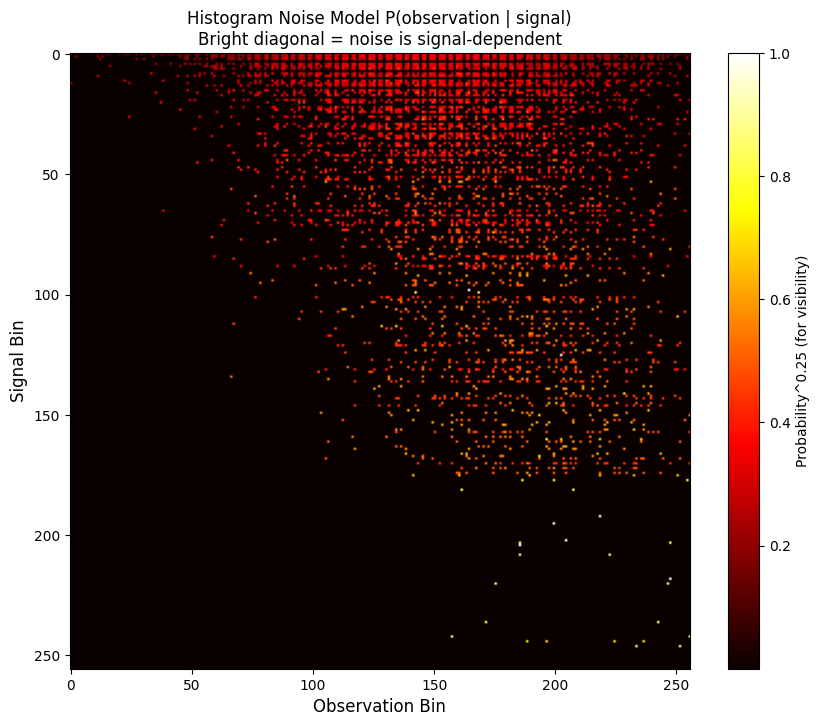

The bright band along the diagonal shows where P(x|s) is highest.
Spread around the diagonal indicates noise variance.


In [8]:
# Visualize the histogram noise model
plt.figure(figsize=(10, 8))
plt.xlabel('Observation Bin', fontsize=12)
plt.ylabel('Signal Bin', fontsize=12)
plt.title('Histogram Noise Model P(observation | signal)\n'
          'Bright diagonal = noise is signal-dependent', fontsize=12)
plt.imshow(histogramFD**0.25, cmap='hot', aspect='auto')
plt.colorbar(label='Probability^0.25 (for visibility)')
plt.show()

print("The bright band along the diagonal shows where P(x|s) is highest.")
print("Spread around the diagonal indicates noise variance.")

### Create GMM Noise Model

The Gaussian Mixture Model provides a smoother, parametric representation:
- More robust with limited calibration data
- Better generalization
- Typically recommended for production use

In [9]:
# Signal intensity range for GMM
min_signal = np.percentile(signal, 0.5)
max_signal = np.percentile(signal, 99.5)

print(f"GMM signal range: [{min_signal:.4f}, {max_signal:.4f}]")

nameGMMNoiseModel = f'GMMNoiseModel_{dataName}_{n_gaussian}_{n_coeff}_calibration'

GMM signal range: [0.0000, 127.0000]


In [10]:
# Create and train GMM noise model
print(f"Training GMM noise model with {n_gaussian} Gaussians...")
print("(This may take a few minutes on CPU)\n")

gmmNoiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(
    min_signal=min_signal,
    max_signal=max_signal,
    path=path,
    weight=None,
    n_gaussian=n_gaussian,
    n_coeff=n_coeff,
    device=device,
    min_sigma=50  # Prevents degenerate solutions
)

# Train on signal-observation pairs
gmmNoiseModel.train(
    signal_for_hist,   # Signal (jittered image)
    obs_for_hist,      # Observation (noisy image)
    batchSize=250000,
    n_epochs=2000,
    learning_rate=0.1,
    name=nameGMMNoiseModel,
    lowerClip=0.5,
    upperClip=99.5
)

print(f"\nSaved: {nameGMMNoiseModel}.npz")

Training GMM noise model with 3 Gaussians...
(This may take a few minutes on CPU)

0 21.218040466308594
100 6.203862190246582
100 6.203862190246582
200 6.066416263580322
200 6.066416263580322
300 6.0156354904174805
300 6.0156354904174805
400 5.995178699493408
400 5.995178699493408
500 5.9853620529174805
500 5.9853620529174805
600 5.979935646057129
600 5.979935646057129
700 5.976609706878662
700 5.976609706878662
800 5.974413871765137
800 5.974413871765137
900 5.972879409790039
900 5.972879409790039
1000 5.971761703491211
1000 5.971761703491211
1100 5.970917701721191
1100 5.970917701721191
1200 5.970263481140137
1200 5.970263481140137
1300 5.969746112823486
1300 5.969746112823486
1400 5.969326972961426
1400 5.969326972961426
1500 5.9689836502075195
1500 5.9689836502075195
1600 5.968697547912598
1600 5.968697547912598
1700 5.968456745147705
1700 5.968456745147705
1800 5.968252658843994
1800 5.968252658843994
1900 5.968076229095459
1900 5.968076229095459

The trained parameters (GMMNoiseM

### Compare Noise Models at Different Signal Levels

Comparing noise models at different signal levels:
Blue = Histogram, Orange = GMM

Signal bin index: 50 (intensity ~ 36.13)
Signal bin index: 128 (intensity ~ 92.50)
Signal bin index: 200 (intensity ~ 144.53)


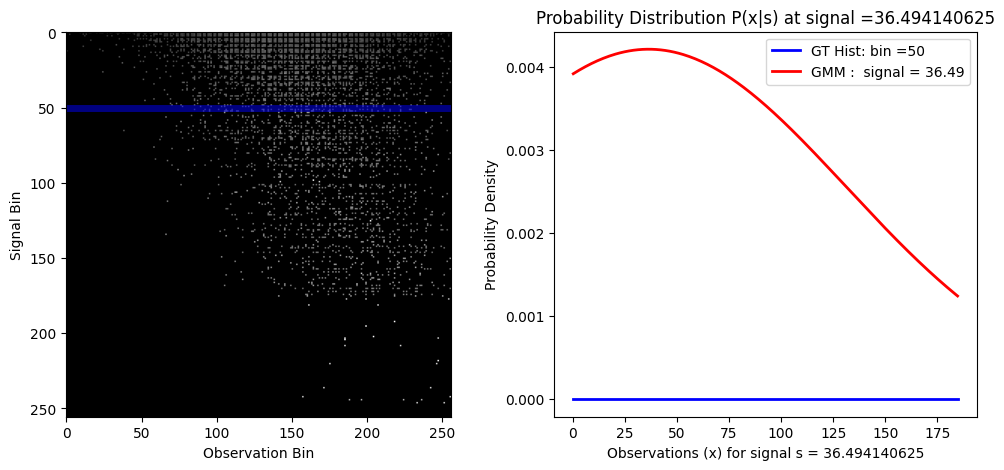

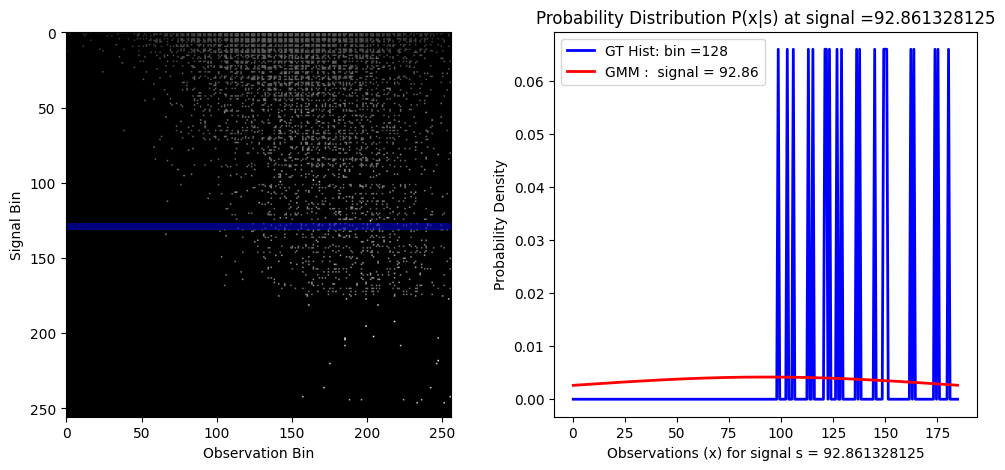

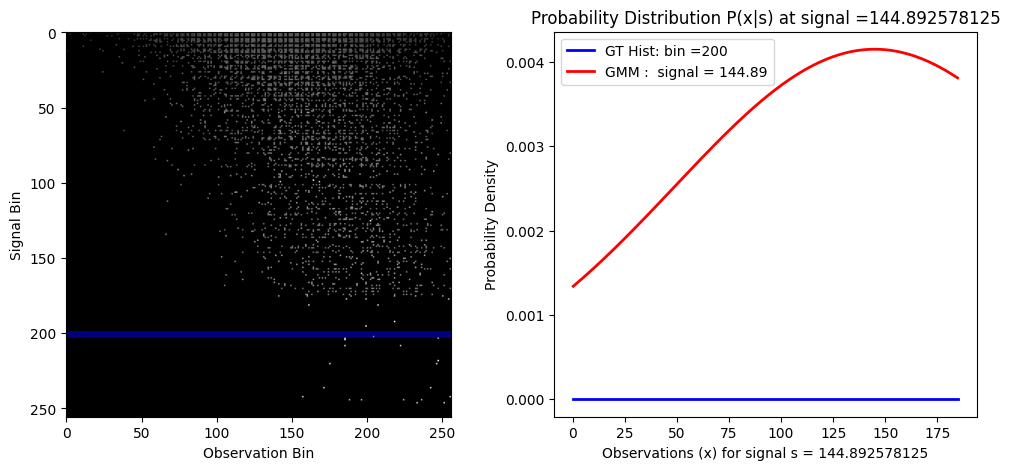

: 

In [ ]:
# Compare histogram and GMM at different signal intensities
print("Comparing noise models at different signal levels:")
print("Blue = Histogram, Orange = GMM\n")

for signalBinIndex in [50, 128, 200]:
    print(f"Signal bin index: {signalBinIndex} (intensity ~ {minVal + signalBinIndex * (maxVal-minVal)/bins:.2f})")
    plotProbabilityDistribution(
        signalBinIndex=signalBinIndex,
        histogram=histogramFD,
        gaussianMixtureNoiseModel=gmmNoiseModel,
        min_signal=minVal,
        max_signal=maxVal,
        n_bin=bins,
        device=device
    )

### Summary

Noise model calibration complete!

**Calibration Data Used:**
- Signal: `jittered_image.tif` (scanning distortions, no noise)
- Observation: `noisy_image_...Gaussian_0.7.tif` (with Gaussian noise σ=0.7)

**Files Saved:**
- `HistNoiseModel_dataset01_calibration.npy` - Histogram noise model
- `GMMNoiseModel_dataset01_3_2_calibration.npz` - GMM noise model (RECOMMENDED)

**Scientific Note:**
We used a single signal-observation pair because:
1. We target a specific noise level (σ=0.7) for fair benchmark comparison
2. Mixing different noise levels would create an invalid composite model
3. The jittered image serves as "clean" signal (contains only scanning artifacts, not noise)

**Next step:** Run `2_PN2VTraining.ipynb`